# Student Data Visualization
In diesem Projekt wird mit anonymisierten und aus Datenschutzgründen verzerrten Studierendendaten gearbeitet.  Enthalten sind Informationen wie Studienstatus, absolvierte ECTS-Punkte pro Semester und viele andere Informationen, jeweils auf Semesterbasis.

Zweck ist, sinnvolle Darstellungen zu finden, die von wenig statistisch geschulten Personen gelesen und eventuell sogar interaktiv „verwendet“ werden können.

### Annahmen / Ziele

• Studierende mit internationalem Hintergrund studieren länger.<br>
• ECTS-Punkte nehmen über den Studienverlauf hinweg ab, um dann gegen Ende wieder anzusteigen.<br>
• Explorativ: Unterschiede zwischen Studiengängen, Identifikation von ECTS-schwachen und ECTS-intensiven Semestern bestimmter Studiengänge

### Prozessschritte

• <b>acquire & parse</b>: Erforderte nur Anonymisierung eines vorhandenen CSV mittels R scripts<br>
• <b>analyze/visualize</b>: seaborn, plotly, plotly express<br>
• <b>interact</b>: Dash und plotly express<br>
• <b>deployment</b>: ???

In [53]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
df_raw = pd.read_csv("student_dummy_data.csv", delimiter=";", encoding="latin-1", decimal=",")

In [4]:
# [print(element) for element in df_raw.columns]
df_raw.columns

Index(['MATRIKELNUMMER', 'STUDBEZ', 'ZULAC', 'SEMESTER_ID', 'STUDIENJAHR',
       'ST_SEM_NR', 'StudienStatusCode', 'StatusgruppeS', 'StatusgruppeSem1',
       'STUDBEZ_kompakt', 'Studart', 'Studgruppe', 'FAMILIENNAME', 'VORNAME',
       'GESCHLECHT', 'LAND_1', 'STUDDAUER', 'OUTGOINGSEM', 'Beginndat_Min',
       'Endedat_Max', 'besuchtesSemester', 'Alter', 'Ueberlaenge',
       'StatusgruppeR', 'ECTS_Sem', 'SWS_Sem', 'ECTS_Sj', 'SWS_Sj', 'prfakt',
       'IncomingsemUHSBV'],
      dtype='object')

In [5]:
df = df_raw.copy()
df["Land"] = "International"
# Variable that splits students in two groups based on Austrian citizenship
df.loc[df['LAND_1'] == "Österreich", 'Land'] = "Österreich"

In [6]:
df_by_semester_and_study_grps = df.groupby(["besuchtesSemester", "STUDBEZ_kompakt"])
df_by_semester_and_study_agg = df_by_semester_and_study_grps["ECTS_Sem"].agg(["mean", "median"])
df_by_semester_and_study_agg = pd.DataFrame(df_by_semester_and_study_agg).reset_index()
df_by_semester_and_study_agg["mean"] = df_by_semester_and_study_agg["mean"].round(1)
df_by_semester_and_study_agg = df_by_semester_and_study_agg.astype({"besuchtesSemester": int})


### Studiendauer und Staatsangehörigkeit
Hier werden alle Beobachtungen (=Semester) mit dem Status "Studienabschluss" betrachtet.

Text(16, 2.1, 'nur 2 Fälle')

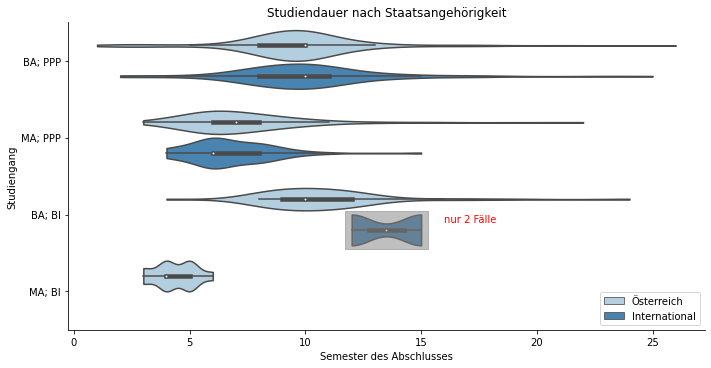

In [67]:

final_semesters = df.loc[df["StatusgruppeR"] == "Studienabschluss"]
#sns.barplot(data = final_semesters, x="Land", y="besuchtesSemester")

myplot = sns.catplot(data=final_semesters, 
            kind="violin", 
            y="STUDBEZ_kompakt",
            order=["BA; PPP", "MA; PPP", "BA; BI", "MA; BI"],
            x="besuchtesSemester",
            hue="Land", 
            cut=0, 
            bw=0.4, 
            legend=False,
            orient="h", 
            aspect=2, 
            palette="Blues")
plt.title("Studiendauer nach Staatsangehörigkeit")
plt.ylabel("Studiengang")
plt.xlabel("Semester des Abschlusses")
plt.legend(loc="lower right")

# getting figure object so gca can be applied
fig = myplot.figure

# this positioning is super clumsy but works for (only) this figure
fig.gca().add_patch(Rectangle((11.7,1.95),3.6,0.5,fill=True, color='gray', alpha=0.5, zorder=100, figure=fig))
plt.text(16, 2.1, "nur 2 Fälle", fontdict={"color": "red"})


Der Violoinenplot weist darauf hin, dass die Studiendauer von internationalen Studierenden nur im Bachelor "Business Intelligence" deutlich länger ist. Allerdings sind hier nur 2 Fälle enthalten, was den Vergleich im Grunde unbrauchbar macht. 

<b>Die Annahme kann also nicht bestätigt werden.</b>

In [ ]:
final_semesters.loc[final_semesters["STUDBEZ_kompakt"] == "BA; BI"]["Land"].value_counts()

Österreich       59
International     2
Name: Land, dtype: int64

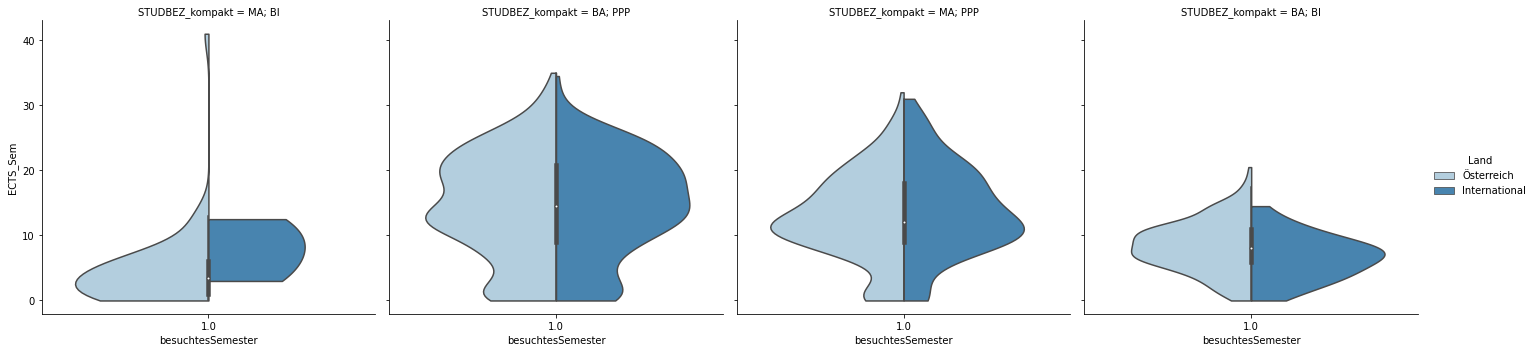

In [71]:
df_reduced = df.loc[df["besuchtesSemester"] == 1]
p = sns.catplot(data=df_reduced, 
kind="violin", 
x="besuchtesSemester", 
y="ECTS_Sem", 
hue="Land", 
col="STUDBEZ_kompakt",
palette="Blues", 
cut=0, 
split=True)
#plt.ylim(0,60)
# would be useful to introduce trim, so that we "zoom in" more

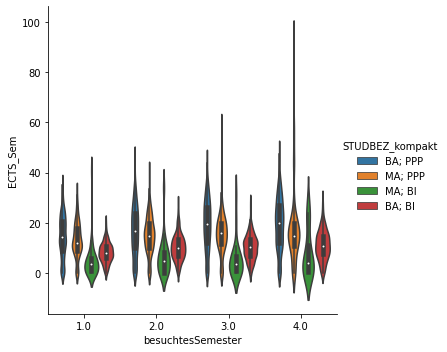

In [40]:
df_reduced = df.loc[df["besuchtesSemester"] <= 4]
sns.catplot(data=df_reduced, 
            kind="violin", 
            x="besuchtesSemester",
            y="ECTS_Sem", 
            hue="STUDBEZ_kompakt", 
            )
 
#plt.ylim(0,60)

# would be useful to introduce trim, so that we "zoom in" more

In [30]:
# sns.catplot(data=df_reduced, kind="violin", x="STUDBEZ_kompakt", y="ECTS_Sem", hue="besuchtesSemester")

In [ ]:
#df_raw.loc[df_raw["StatusgruppeR"] != "Beurlaubung"]

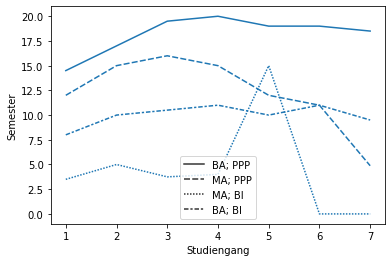

In [29]:
sns.lineplot(data=df_raw.loc[(df_raw["StatusgruppeR"] != "Beurlaubung") &
                            (df_raw["besuchtesSemester"] < 8)], 
            x="besuchtesSemester", 
            y="ECTS_Sem", 
            #hue="STUDBEZ_kompakt", 
            ci=None, 
            estimator="median", 
            style="STUDBEZ_kompakt")
plt.xlabel("Studiengang")
plt.ylabel("Semester")
plt.legend(loc="best")

([<matplotlib.axis.XTick at 0x25ffe42adc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

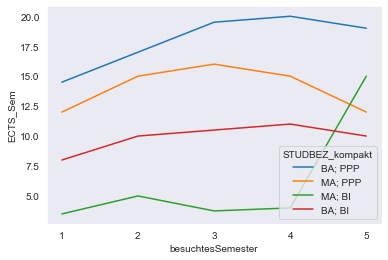

In [ ]:
sns.set_style("dark")
sns.lineplot(data=df_raw.loc[df_raw.besuchtesSemester < 6], 
            x="besuchtesSemester", 
            y="ECTS_Sem", 
            hue="STUDBEZ_kompakt", 
            ci=None, 
            estimator="median")
plt.xticks(df_raw.loc[df_raw.besuchtesSemester < 6]["besuchtesSemester"].unique())

In [ ]:
df_raw.loc[df_raw.besuchtesSemester < 9]

,MATRIKELNUMMER,STUDBEZ,ZULAC,SEMESTER_ID,STUDIENJAHR,ST_SEM_NR,StudienStatusCode,StatusgruppeS,StatusgruppeSem1,STUDBEZ_kompakt,...,besuchtesSemester,Alter,Ueberlaenge,StatusgruppeR,ECTS_Sem,SWS_Sem,ECTS_Sj,SWS_Sj,prfakt,IncomingsemUHSBV
0,801535,Bachelorstudium; Powerpoint,O,21S,2020/21,102,IX,Studienabschluss,,BA; PPP,...,6.0,34,-2.0,Studienabschluss,33.0,0.0,33.00,0.0,superprfakt,NaN
1,11932730,Bachelorstudium; Powerpoint,O,21S,2020/21,102,IX,Studienabschluss,,BA; PPP,...,3.0,28,-5.0,Studienabschluss,33.0,0.0,33.00,2.0,superprfakt,NaN
2,11935933,Bachelorstudium; Powerpoint,O,21S,2020/21,102,Bp,Studienunterbrechung_Ende,,BA; PPP,...,3.0,28,-5.0,Studienunterbrechung_Ende,32.0,0.0,32.00,0.0,superprfakt,NaN
3,1340104,Masterstudium; Powerpoint,O,21S,2020/21,102,IX,Studienabschluss,,MA; PPP,...,4.0,25,0.0,Studienabschluss,93.0,9.0,113.75,13.0,superprfakt,NaN
4,864344,Masterstudium; Powerpoint,O,19S,2018/19,98,IX,Studienabschluss,,MA; PPP,...,6.0,27,2.0,Studienabschluss,71.5,6.0,82.00,11.0,superprfakt,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15977,1184175,Masterstudium; Business Intelligence,O,20S,2019/20,100,I,Studienfortsetzung,,MA; BI,...,2.0,45,-2.0,Studienfortsetzung,0.0,0.0,0.00,0.0,zu wenig,NaN
15978,871547,Masterstudium; Business Intelligence,O,20S,2019/20,100,aB,Studienbeginn,,MA; BI,...,2.0,33,-2.0,Studienbeginn,0.0,0.0,0.00,0.0,keine Prüfungsaktivität,NaN
15979,1469750,Masterstudium; Business Intelligence,O,20S,2019/20,100,I,Studienfortsetzung,,MA; BI,...,2.0,26,-2.0,Studienfortsetzung,0.0,0.0,1.50,1.0,zu wenig,NaN
15983,1544673,Masterstudium; Business Intelligence,O,21S,2020/21,102,I,Studienfortsetzung,,MA; BI,...,1.0,39,-3.0,Studienfortsetzung,0.0,0.0,0.00,0.0,zu wenig,NaN
